In [23]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt 
import numpy as np

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback/')
import functions.data_wrangling as data 

In [24]:
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/regridded/AWI_3x3_ef.nc')
# ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/regridded/CanESM5_3x3_ef.nc')
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/regridded/FGOALS-f3-L_3x3_ef.nc')

# Take seasonal mean
ds = data.seasonal_dataset(ds, season='djf')
ds = ds.mean('time')

# Subset to NH and cut top of atmos. and poles
ds = ds.sel(lat=slice(0,90))
ds['level'] = ds['level'] / 100
ds = ds.where(ds.level > 10., drop=True)
ds = ds.sel(lat=slice(0,84))

ds 

<xarray.Dataset>
Dimensions:  (ens_ax: 100, level: 7, lat: 29)
Coordinates:
  * level    (level) float64 1e+03 850.0 700.0 500.0 250.0 100.0 50.0
  * lat      (lat) int64 0 3 6 9 12 15 18 21 24 ... 60 63 66 69 72 75 78 81 84
Dimensions without coordinates: ens_ax
Data variables:
    ubar     (ens_ax, level, lat) float32 dask.array<chunksize=(100, 7, 29), meta=np.ndarray>
    div1     (ens_ax, level, lat) float64 dask.array<chunksize=(100, 7, 29), meta=np.ndarray>

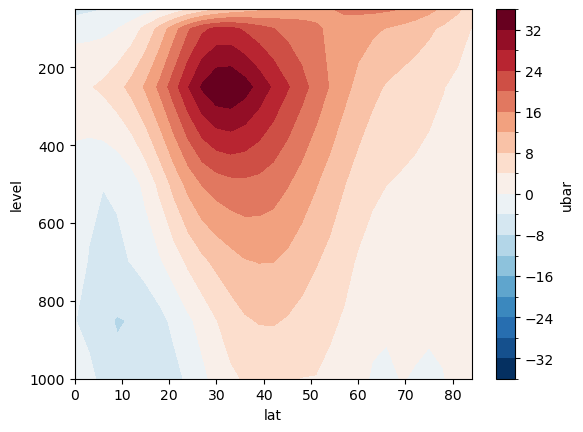

In [25]:
ds.ubar.mean('ens_ax').plot.contourf(yincrease=False, levels=20, yscale='linear')

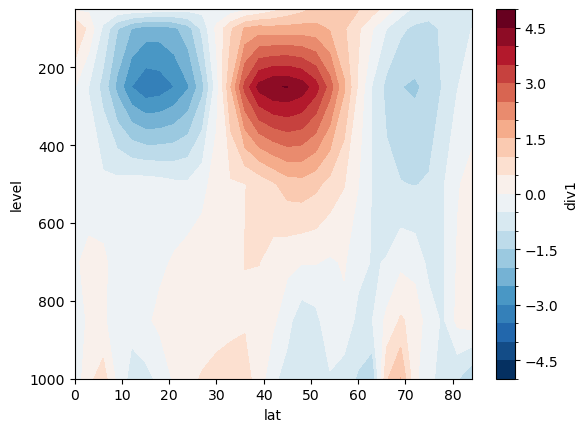

In [26]:
ds.div1.mean('ens_ax').plot.contourf(yincrease=False, levels=20, yscale='linear')

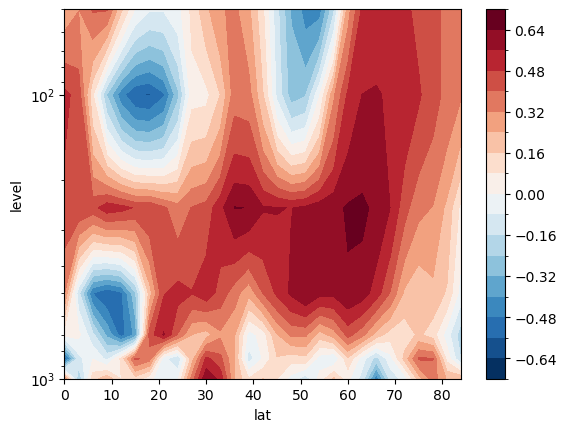

In [27]:
# Set variables
ubar = ds.ubar
div1 = ds.div1 

# Calculate correlation
corr = xr.corr(div1, ubar, dim='ens_ax')

corr.plot.contourf(yincrease=False, levels=20, yscale='log')

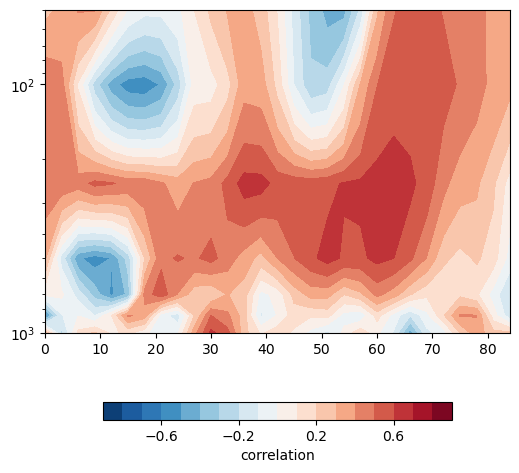

In [28]:
plt.figure(figsize=(6,6))
plt.contourf(corr.lat.values, corr.level.values, corr, levels=np.linspace(-0.9,0.9,19),
             cmap='RdBu_r')
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.75, label='correlation',
             extend='both', ticks=[-0.6,-0.2,0.2,0.6])
plt.gca().invert_yaxis()
plt.yscale('log')
plt.show() 

# Function

In [29]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/regridded/AWI_3x3_ef.nc')

def plot_pamip_correlation(ds, check_vars=False, take_seasonal=True, logscale=True, show_rect=True,
                           top_atmos=10., cut_poles=90, label='DJF'):
    
    """"
    Input: DataArrays of ubar and F_\\phi with PAMIP data
            - Dims: (ens_ax, time, level, lat)
    
    Output: contourf plot replicating Fig.6a in Smith et al., 2022 
    """
    
    ## SET UP TIME

    # If required, check dimensions and variables are labelled correctly
    if check_vars:
        ds = data.check_dimensions(ds, ignore_dim='lon')
        ds = data.check_variables(ds) 
    
    if take_seasonal:
        ds = data.seasonal_dataset(ds, season='djf')
        ds = ds.mean('time')
    
    # Take seasonal mean
    ds = data.seasonal_dataset(ds, season='djf')
    ds = ds.mean('time')

    # Subset to NH and cut top of atmos. and poles
    # Can choose latitude cut-off
    ds = ds.sel(lat=slice(0,cut_poles))
    
    # Cut off top of atmosphere
    ds['level'] = ds['level'] / 100
    ds = ds.where(ds.level > top_atmos, drop=True)
    
    # Calculate correlation
    corr = xr.corr(div1, ubar, dim='ens_ax')
        
        
#------------------------------------------------------------------
    
    ## PLOTTING TIME

    # Initiate plot
    plt.figure(figsize=(6,6))

    # actual plotting
    plt.contourf(corr.lat.values, corr.level.values, corr, cmap='RdBu_r', levels=np.linspace(-0.9,0.9,19),
             extend='both')
    plt.colorbar(location='bottom', orientation='horizontal', shrink=0.75, label='correlation',
             extend='both', ticks=[-0.6,-0.2,0.2,0.6])
    
    # axis alterations
    plt.gca().invert_yaxis()
    plt.xlabel('Latitude $(^\\circ N)$')
    if logscale:
        plt.yscale('log')
        plt.ylabel('Log pressure (hPa)')
    else:
        plt.ylabel('Pressure (hPa)')
    plt.title(f'$Corr(\\bar{{u}}, \\nabla_{{\\phi}} F_{{\\phi}})$ - {label}')

    # Plot EFP box
    if show_rect:
        import matplotlib.patches as patches
        rect = patches.Rectangle((25.,600.), 50, -400, 
                         fill=False, linewidth=2)
        plt.gca().add_patch(rect)

    plt.show()

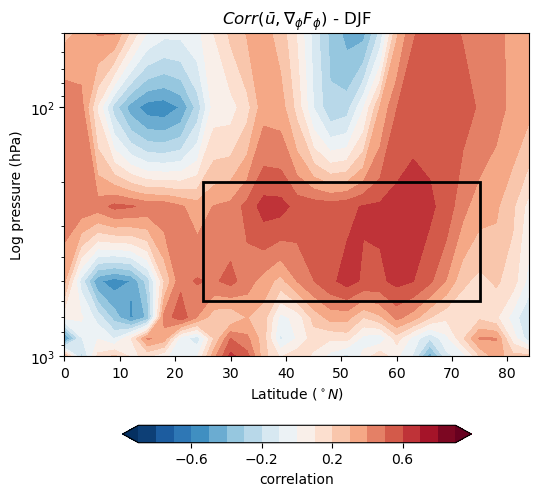

In [30]:
plot_pamip_correlation(ds, take_seasonal=False, cut_poles=84)

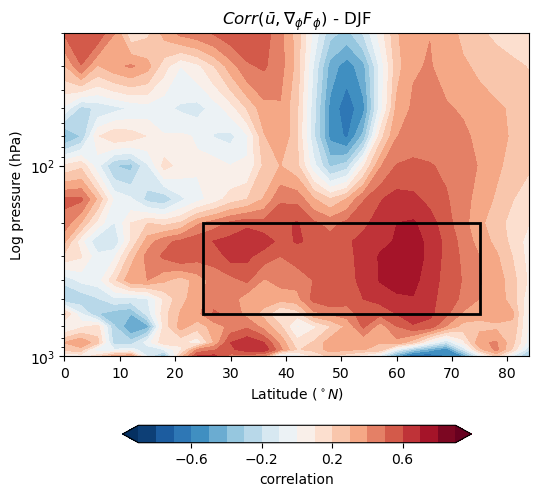

In [31]:
import functions.plotting as plot

plot.plot_pamip_correlation(ds, take_seasonal=False, cut_poles=84)